In [96]:
import pandas as pd
import numpy as np
from itertools import cycle

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [97]:
from sklearn import tree, svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [32]:
sns.set(rc={'figure.figsize': (9, 6)})

In [33]:
titanic_data = pd.read_csv('titanic/train.csv')

In [34]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [36]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_data.Survived

In [37]:
X = pd.get_dummies(X)

In [38]:
X = X.fillna({'Age': X.Age.median()})

In [39]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [40]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [43]:
clf.score(X_test, y_test)

0.7796610169491526

In [44]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [45]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [46]:
clf.score(X_test, y_test)

0.8101694915254237

In [47]:
max_depth_values = range(1, 100)

In [48]:
scores = pd.DataFrame()

In [49]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores = pd.concat([
        scores,
        pd.DataFrame({
            'max_depth': [max_depth],
            'train_score': [train_score],
            'test_score': [test_score],
            'cross_val_score': [mean_cross_val_score]
        }),
    ], ignore_index=True)

In [50]:
scores.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
1,2,0.805369,0.776271,0.770196
2,3,0.823826,0.820339,0.790322
3,4,0.833893,0.823729,0.788627
4,5,0.840604,0.806780,0.793669


In [51]:
scores_data_long = pd.melt(scores,
        id_vars=['max_depth'],
        value_vars=['train_score', 'test_score', 'cross_val_score'],
        var_name='set_type',
        value_name='score'
        )

In [52]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


<AxesSubplot:xlabel='max_depth', ylabel='score'>

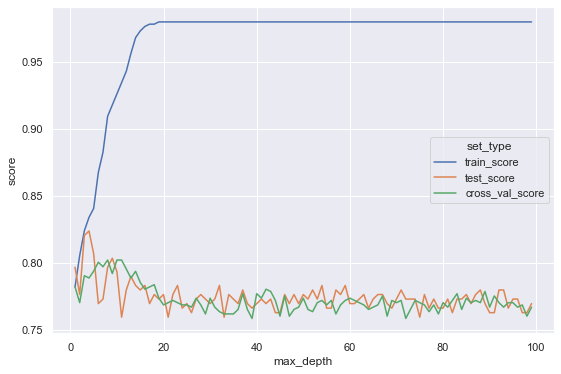

In [53]:
sns.lineplot(data=scores_data_long, x='max_depth', y='score', hue='set_type')

In [54]:
scores_data_long.query('set_type == "cross_val_score"').head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.793669
203,6,cross_val_score,0.800392
204,7,cross_val_score,0.797017
205,8,cross_val_score,0.802045
206,9,cross_val_score,0.791947
207,10,cross_val_score,0.802031


In [55]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [56]:
cross_val_score(clf, X_test, y_test, cv=5).mean()

0.7898305084745763

In [58]:
clf = tree.DecisionTreeClassifier()

In [59]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 30)
}

In [60]:
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=5)

In [61]:
grid_search_cv_clf.fit(X_test, y_test)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [62]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [63]:
best_clf = grid_search_cv_clf.best_estimator_

In [65]:
best_clf.score(X_test, y_test)

0.8711864406779661

In [66]:
y_true = y_test

In [67]:
y_pred = best_clf.predict(X_test)

In [69]:
precision_score(y_true, y_pred)

0.8059701492537313

In [70]:
recall_score(y_true, y_pred)

0.9

In [71]:
f1_score(y_true, y_pred)

0.8503937007874016

In [72]:
y_predicted_prob = best_clf.predict_proba(X_test)

In [75]:
y_predicted_prob

array([[0.        , 1.        ],
       [0.95833333, 0.04166667],
       [1.        , 0.        ],
       [0.22857143, 0.77142857],
       [0.22857143, 0.77142857],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.83333333, 0.16666667],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.34375   , 0.65625   ],
       [0.81481481, 0.18518519],
       [1.        , 0.        ],
       [0.92      , 0.08      ],
       [0.95833333, 0.04166667],
       [0.        , 1.        ],
       [0.34375   , 0.65625   ],
       [0.        , 1.        ],
       [0.95833333, 0.04166667],
       [0.34375   , 0.65625   ],
       [1.        , 0.        ],
       [0.34375   , 0.65625   ],
       [0.22857143, 0.77142857],
       [0.81481481, 0.18518519],
       [0.95833333, 0.04166667],
       [0.83333333, 0.16666667],
       [0.34375   , 0.65625   ],
       [0.95833333, 0.04166667],
       [0.83333333, 0.16666667],
       [0.35      , 0.65      ],
       [1.

<AxesSubplot:>

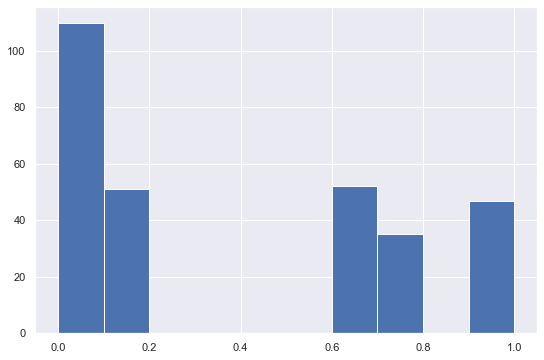

In [78]:
pd.Series(y_predicted_prob[:,1]).hist()

In [92]:
y_pred = np.where(y_predicted_prob[:,1] > 0.2, 1, 0)

In [93]:
precision_score(y_true, y_pred)

0.8059701492537313

In [94]:
recall_score(y_true, y_pred)

0.9

In [95]:
f1_score(y_true, y_pred)

0.8503937007874016

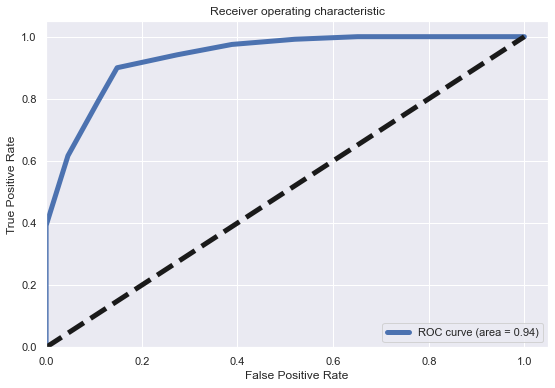

In [127]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc), lw=5)
plt.plot([0, 1], [0, 1], 'k--', lw=5)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')